# Look-A-Like Model

## Dataset
- [Social Network Ads](https://www.kaggle.com/datasets/rakeshrau/social-network-ads/data) A categorical dataset to determine whether a user purchased a particular product
## Reference
- [Un-supervised Look-a-like model](https://github.com/nikhitmago/lookalike-modelling/blob/master/train.py)

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from xgboost import XGBClassifier
import lightgbm as lgb

# Model Evaluation
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix, f1_score


In [2]:
palette = [ '#0077b6' , '#00b4d8' , '#90e0ef' , '#caf0f8']
# color_palette = sns.color_palette(palette)
sns.set_palette(palette)
sns.set_style('whitegrid')

import warnings 
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../../../data/common_datasets/social_network_ads.csv')

In [4]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [5]:
df = df.set_index("User ID")

In [6]:
df.shape

(400, 4)

In [7]:
df.Purchased.value_counts(normalize=True)

Purchased
0    0.6425
1    0.3575
Name: proportion, dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 15624510 to 15594041
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           400 non-null    object
 1   Age              400 non-null    int64 
 2   EstimatedSalary  400 non-null    int64 
 3   Purchased        400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.6+ KB


## EDA

### Missing Values

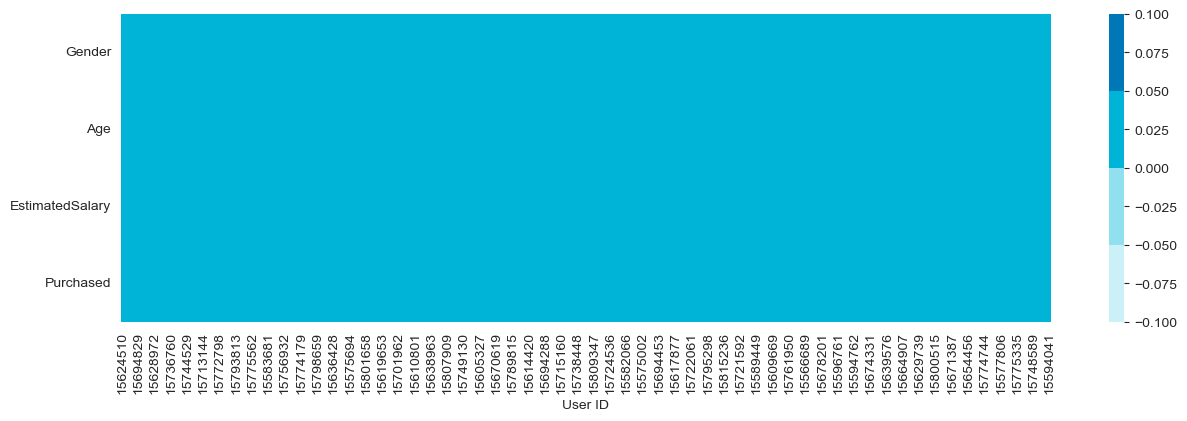

In [9]:
#Showing missing data at which index of the data
fig, ax = plt.subplots(figsize=(15,4)) 
sns.heatmap(df.isna().transpose(), ax=ax, cmap= palette[::-1] )
plt.show()

### Target Visualisation
- Visualize the nature of purchased and non-purchased customers using T-SNE. 
    - T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.

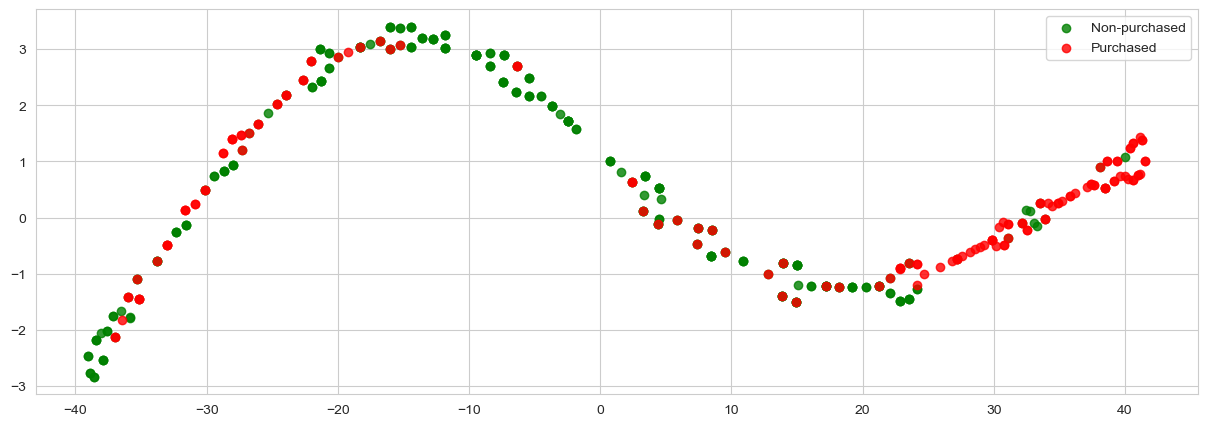

In [10]:
def tsne_plot(x, y):
    tsne = TSNE(n_components=2, random_state=2024)
    X_t = tsne.fit_transform(x)

    plt.figure(figsize=(15, 5))

    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non-purchased')
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Purchased')

    plt.legend(loc='best');
    plt.show();
    
tsne_plot(x=df[["Age","EstimatedSalary"]], y=df["Purchased"])

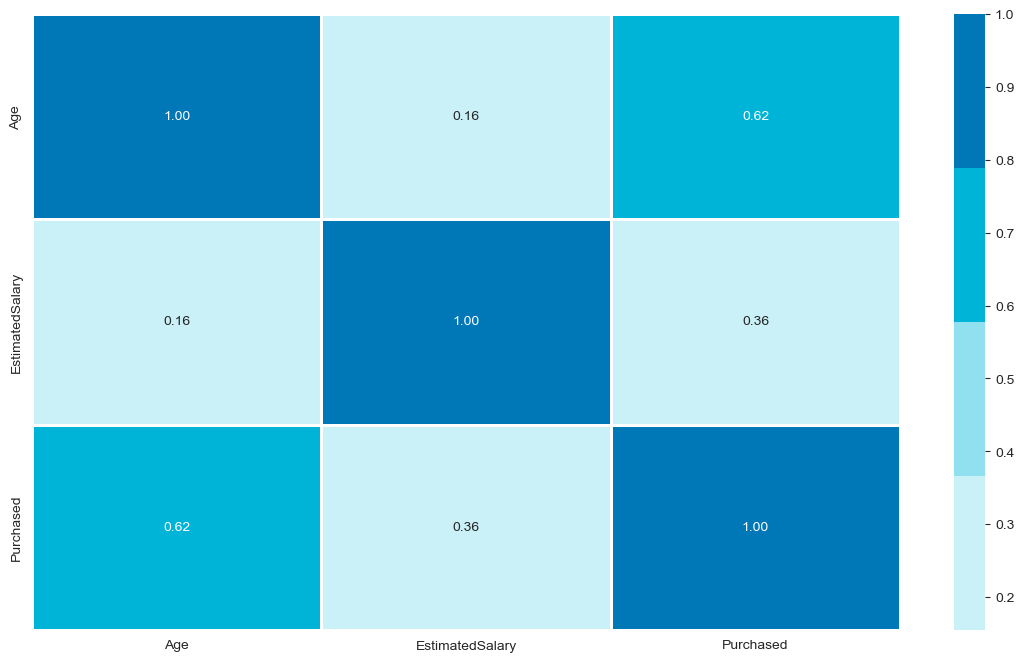

In [11]:
corr_df = df.drop(columns=["Gender"]).corr()
plt.figure(figsize= (14, 8))
sns.heatmap(corr_df, annot = True, fmt = '.2f', linewidths= 0.8, cmap=palette[::-1])
plt.show()

- From the above graph we can observe that there are many non-purchased customers which are very close to purchased customers, thus are difficult to accurately classify from a model.

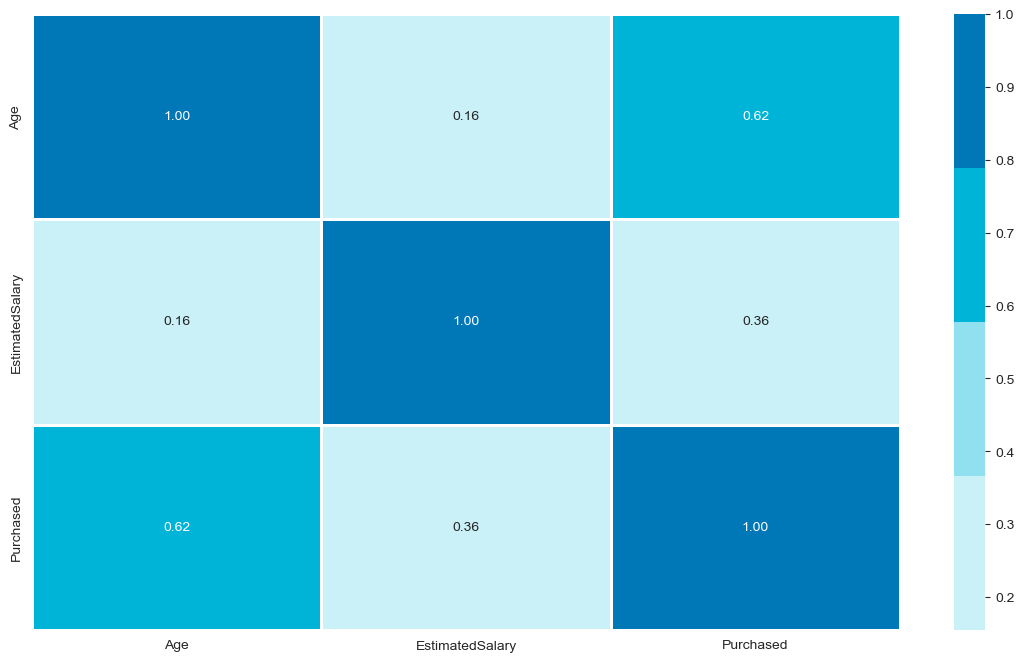

In [12]:
corr_df = df.drop(columns=["Gender"]).corr()
plt.figure(figsize= (14, 8))
sns.heatmap(corr_df, annot = True, fmt = '.2f', linewidths= 0.8, cmap=palette[::-1])
plt.show()

<Axes: xlabel='Gender', ylabel='count'>

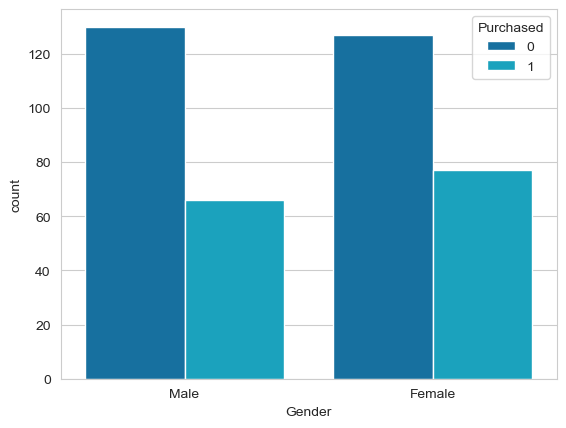

In [105]:
sns.countplot(df, x='Gender', hue = 'Purchased')

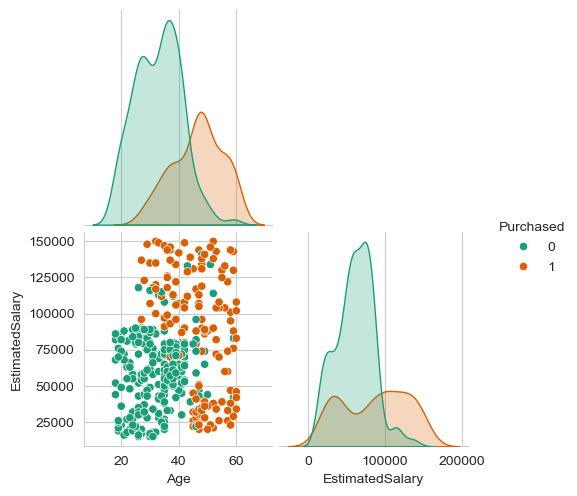

In [13]:
sns.pairplot(df , hue = 'Purchased', palette='Dark2',corner=True );

- Age & Estimated Salary vs Target

<Axes: xlabel='Age', ylabel='EstimatedSalary'>

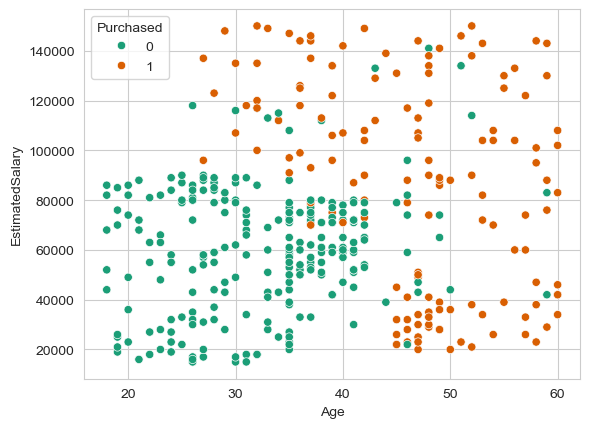

In [14]:
sns.scatterplot(x = 'Age',y = 'EstimatedSalary', data = df, hue = 'Purchased', palette ='Dark2')

## Train Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Purchased"]), df["Purchased"], stratify=df["Purchased"])

In [16]:
y_train.value_counts(normalize=True).round(2)

Purchased
0    0.64
1    0.36
Name: proportion, dtype: float64

In [17]:
y_test.value_counts(normalize=True).round(2)

Purchased
0    0.64
1    0.36
Name: proportion, dtype: float64

### Binning Age

In [18]:
# Step 1: use pd.qcut to determine the range based on the quantile
# pd.qcut(X_train['Age'], q=5)
# This is determined by pd.qcut: (17.999, 27.0] < (27.0, 35.0] < (35.0, 39.0] < (39.0, 47.0] < (47.0, 60.0]
def binning_age(age_col: pd.Series) -> pd.Series:
    return pd.cut(
        age_col,
        bins=[-np.inf, 18, 27, 35, 39, 47, 60, np.inf],
        labels=["18 and under", "19-27", "28-35", "36-39", "40-47", "48-60", "60+"],
    )

X_train["Age_Bin"] = binning_age(X_train["Age"])
X_test["Age_Bin"] = binning_age(X_test["Age"])


In [19]:
num_pipeline = make_pipeline(
                SimpleImputer(strategy="median"),
                StandardScaler()
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder())
num_attribs = ["EstimatedSalary"]
cat_attribs = ["Age_Bin", "Gender"]

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
    ],
    remainder='drop',   # 'drop' and 'passthrough'
    n_jobs=-1          # n_job = -1 means that we'll be using all processors to run in parallel.
)

In [20]:
X_train_transformed=preprocessing.fit_transform(X_train)
X_test_transformed=preprocessing.transform(X_test)

In [21]:
column_names = preprocessing.get_feature_names_out()

X_train_transformed =pd.DataFrame(X_train_transformed, columns=column_names, index=X_train.index)
X_test_transformed  =pd.DataFrame(X_test_transformed, columns=column_names, index=X_test.index)
X_train_transformed.head()

,num__EstimatedSalary,cat__Age_Bin_18 and under,cat__Age_Bin_19-27,cat__Age_Bin_28-35,cat__Age_Bin_36-39,cat__Age_Bin_40-47,cat__Age_Bin_48-60,cat__Gender_Female,cat__Gender_Male
User ID,,,,,,,,,
15685346,1.876417,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
15689425,-0.633973,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
15756820,-0.992600,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15584545,0.471794,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15699247,0.172938,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
X_train.head()

,Gender,Age,EstimatedSalary,Age_Bin
User ID,,,,
15685346,Male,56,133000,48-60
15689425,Male,30,49000,28-35
15756820,Female,28,37000,28-35
15584545,Female,32,86000,28-35
15699247,Male,31,76000,28-35


## Model Training

### Supervised Learning
- Since the "1" target is minority, this is a very imbalance supervised learning problem.
- Hence, we only use the supervised learning approach to get the top feature importance's core, so that we can use to the feature importance to play as the score * features to fit into the unsupervised learning

#### K Nearest Neighbor (KNN)
- KNN considers similar things exist in close proximity or distance and there is no need to build a model, as it tunes several parameters, or makes additional assumptions. KNN is versatile but gets slower as the features increase.



In [23]:
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train_transformed, y_train)

KNeighborsClassifier()

In [24]:
def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    y_pred_proba = model.predict_proba(X_test)
    pos_probs = y_pred_proba[:, 1]
    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y_test, pos_probs)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, pos_probs)
    print(f'PR AUC: {pr_auc:.3f}')
    print(f'ROC AUC: {roc_auc:.3f}')

    # Generate array of values for confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cm,annot=True, cmap=palette[::-1])
    ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']) 
    ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])

              precision    recall  f1-score   support

           0       0.98      0.86      0.92        64
           1       0.80      0.97      0.88        36

    accuracy                           0.90       100
   macro avg       0.89      0.92      0.90       100
weighted avg       0.91      0.90      0.90       100

PR AUC: 0.940
ROC AUC: 0.968


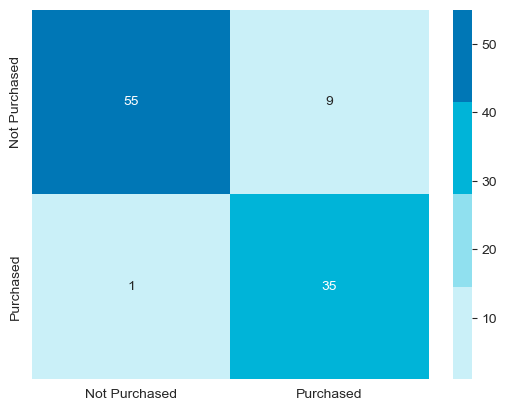

In [25]:
eval_model(knn_classifier, X_test_transformed, y_test)

##### Choosing the optimal K
- Choice of k is very critical. A small value of k means that noise will have a higher influence on the result. A large value makes it computationally expensive and is contradictory to the basic idea behind KNN, that close points might have similar densities or classes.

In [26]:
error_rate = []

for i in tqdm(range(1,40)):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_transformed, y_train)
    pred_i = knn.predict(X_test_transformed)
    error_rate.append(np.mean(pred_i != y_test))

100%|██████████| 39/39 [00:00<00:00, 341.77it/s]


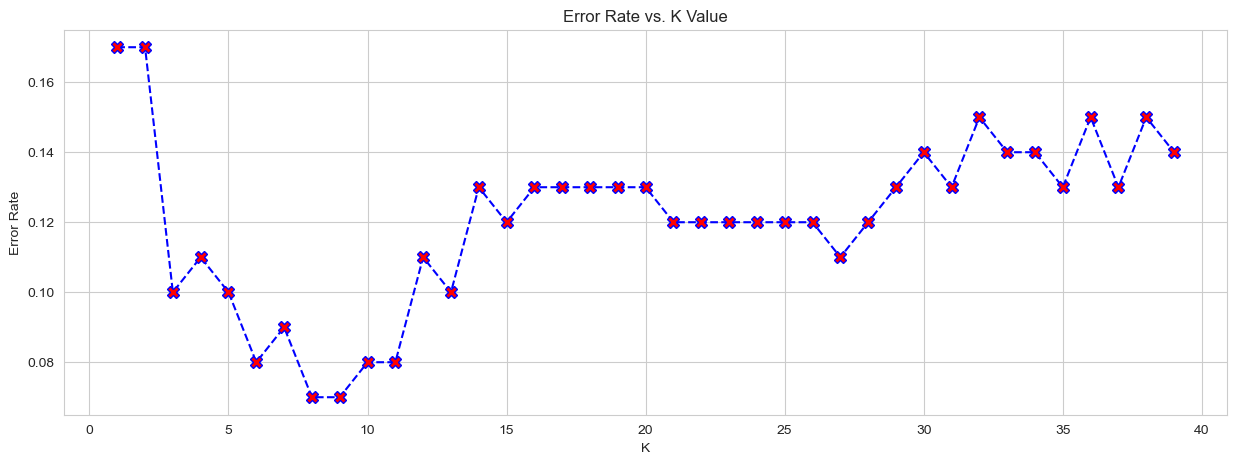

In [27]:
plt.figure(figsize=(15,5))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='X',
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

#### Random Forest

In [28]:
# Random Forest Model
rf_classifier = RandomForestClassifier(random_state=2024, max_depth=10)
rf_classifier.fit(X_train_transformed,y_train)

RandomForestClassifier(max_depth=10, random_state=2024)

              precision    recall  f1-score   support

           0       0.87      0.86      0.87        64
           1       0.76      0.78      0.77        36

    accuracy                           0.83       100
   macro avg       0.81      0.82      0.82       100
weighted avg       0.83      0.83      0.83       100

PR AUC: 0.883
ROC AUC: 0.942


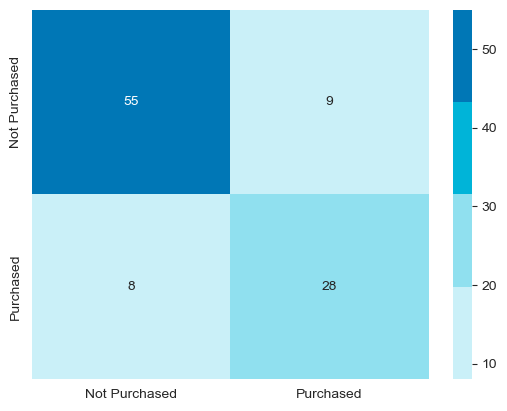

In [29]:
eval_model(rf_classifier, X_test_transformed, y_test)

In [30]:
rf_classifier.__class__.__name__

'RandomForestClassifier'

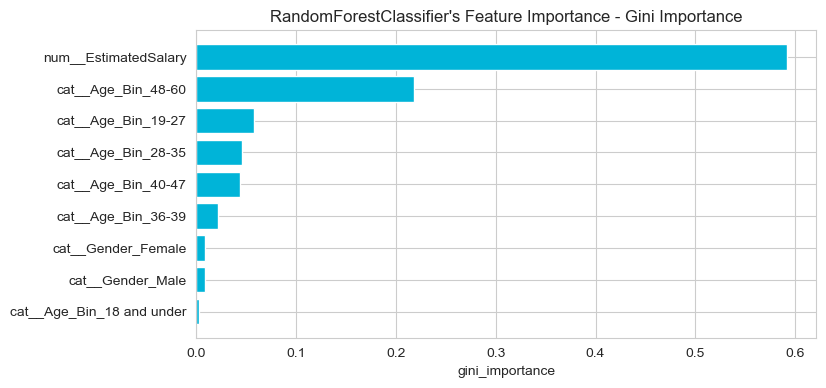

,feature,gini_importance
0,num__EstimatedSalary,0.591528
6,cat__Age_Bin_48-60,0.218421
2,cat__Age_Bin_19-27,0.057955
3,cat__Age_Bin_28-35,0.046002
5,cat__Age_Bin_40-47,0.043888
4,cat__Age_Bin_36-39,0.022253
7,cat__Gender_Female,0.009026
8,cat__Gender_Male,0.008585
1,cat__Age_Bin_18 and under,0.002341


In [31]:
def get_feature_importances(ml_model):
    # Built-in feature importance (Gini Importance)
    importances = ml_model.feature_importances_
    feature_imp_df = pd.DataFrame({'feature': column_names, 'gini_importance': importances}).sort_values('gini_importance', ascending=False) 

    # Create a bar plot for feature importance
    plt.figure(figsize=(8, 4))
    plt.barh(feature_imp_df['feature'], feature_imp_df['gini_importance'], color=palette[1])
    plt.xlabel("gini_importance")
    plt.title(f"{ml_model.__class__.__name__}'s Feature Importance - Gini Importance")
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

    return feature_imp_df

get_feature_importances(rf_classifier)

#### XGBoost

In [32]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic',random_state=42)

xgb.fit(X_train_transformed,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        64
           1       0.74      0.86      0.79        36

    accuracy                           0.84       100
   macro avg       0.83      0.84      0.83       100
weighted avg       0.85      0.84      0.84       100

PR AUC: 0.807
ROC AUC: 0.928


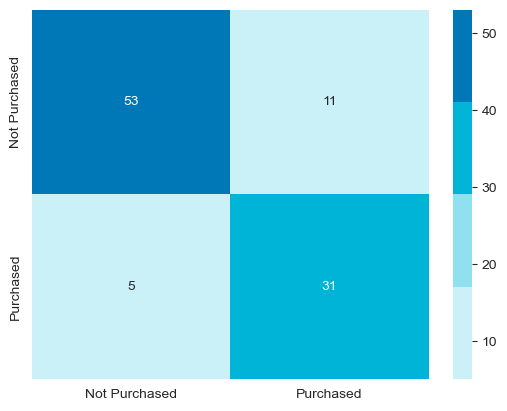

In [33]:
eval_model(xgb, X_test_transformed, y_test)

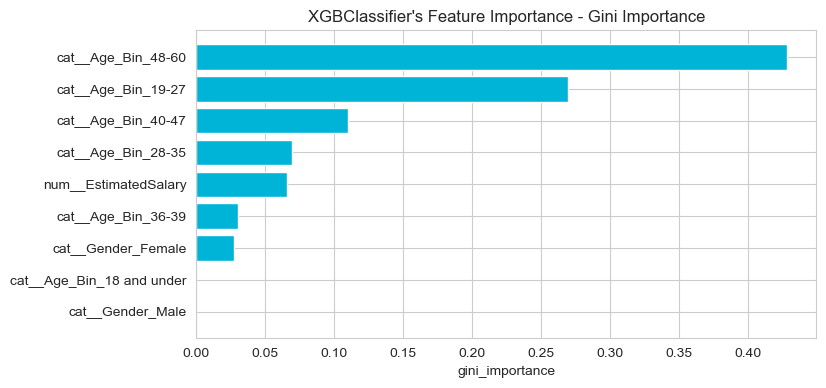

,feature,gini_importance
6,cat__Age_Bin_48-60,0.428362
2,cat__Age_Bin_19-27,0.269370
5,cat__Age_Bin_40-47,0.109819
3,cat__Age_Bin_28-35,0.069359
0,num__EstimatedSalary,0.065821
4,cat__Age_Bin_36-39,0.030199
7,cat__Gender_Female,0.027070
1,cat__Age_Bin_18 and under,0.000000
8,cat__Gender_Male,0.000000


In [34]:
get_feature_importances(xgb)

#### LightGBM

In [35]:
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(X_train_transformed,
            y_train,
            eval_metric='pr_auc',
            eval_set=[(X_test_transformed, y_test)],
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 107, number of negative: 193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356667 -> initscore=-0.589861
[LightGBM] [Info] Start training from score -0.589861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMClassifier()

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        64
           1       0.72      0.86      0.78        36

    accuracy                           0.83       100
   macro avg       0.82      0.84      0.82       100
weighted avg       0.84      0.83      0.83       100

PR AUC: 0.847
ROC AUC: 0.928


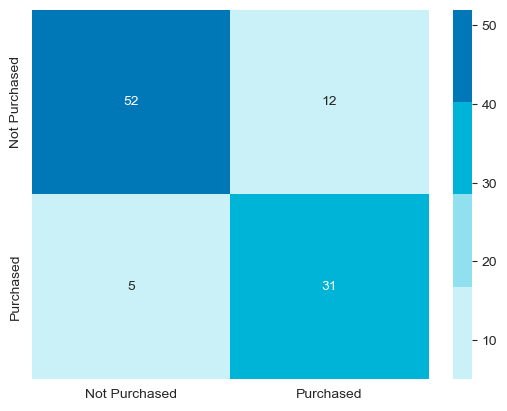

In [36]:
eval_model(lgb_classifier, X_test_transformed, y_test)

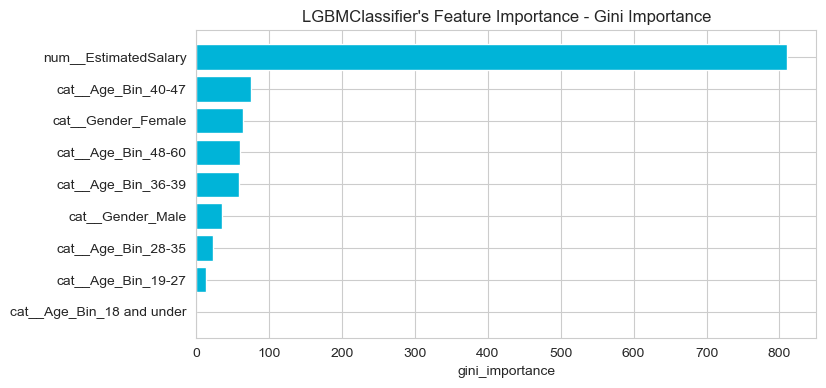

In [37]:
lgbm_fi_df = get_feature_importances(lgb_classifier)

In [38]:
lgbm_fi_df["gini_importance_norm"] = lgbm_fi_df["gini_importance"]/ lgbm_fi_df["gini_importance"].sum()

In [39]:
lgbm_fi_df.head()

,feature,gini_importance,gini_importance_norm
0,num__EstimatedSalary,810,0.711150
5,cat__Age_Bin_40-47,75,0.065847
7,cat__Gender_Female,64,0.056190
6,cat__Age_Bin_48-60,60,0.052678
4,cat__Age_Bin_36-39,58,0.050922


- Plot the tsne score with the top feature importance to see if the clusters are separated.

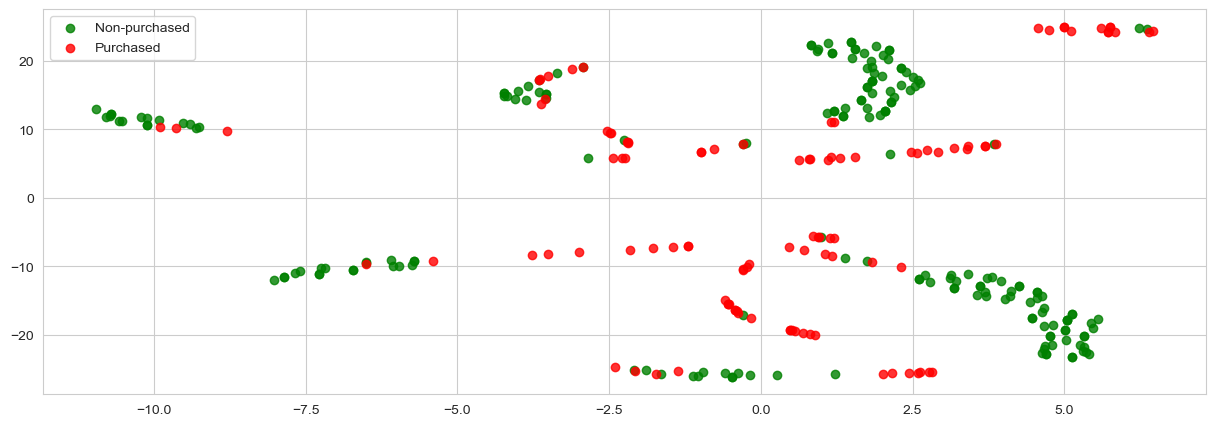

In [40]:
tsne_plot(x=X_train_transformed[["num__EstimatedSalary",
                                 "cat__Age_Bin_48-60", 
                                 "cat__Age_Bin_40-47",
                                 "cat__Age_Bin_36-39",
                                 "cat__Gender_Female",
                                 "cat__Gender_Male",
                                 ]], 
          y=y_train)

### Unsupervised Learning

In [132]:
# only get the "1" target features
knn_train = X_train_transformed.loc[y_train[y_train == 1].index]
# select only top 5 features based on the LightGBM to build the clustering
top_features = lgbm_fi_df['feature'].head(6)
knn_train = knn_train[top_features]
knn_full_train = X_train_transformed[top_features] # full i.e contains both 0 & 1
knn_full_test = X_test_transformed[top_features]   # full i.e contains both 0 & 1

In [110]:
class KnnCluster:
    def __init__(self, min_n_neighbors, max_n_neighbors, metrics_fn) -> None:
        self.number_of_neighbours = range(min_n_neighbors, max_n_neighbors+1)
        self.algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
        self.metrics_fn = metrics_fn
    
    def _fit(self, n_neighbors, algorithm, X_train):
        # Initiating nearest neighbor search
        neighbors = NearestNeighbors(n_neighbors = n_neighbors, 
                                     algorithm = algorithm).fit(X_train)
        return neighbors
    
    def aggregate_distances(self, y_eval, knn_distances, plot_histogram=False):
        eval_df = pd.DataFrame({
                    'ground_truth': y_eval,
                    'distance': np.mean(knn_distances, axis=1)
                }, index=y_eval.index)
        if plot_histogram:
            ax = sns.histplot(eval_df, x='distance', hue='ground_truth', palette ='Dark2')
            plt.show()
        return eval_df
    
    def _find_best_threshold(self, eval_df, scale=100):
        best_metrics, best_threshold = float("-inf"), eval_df['distance'].max()
        min_dist, max_dist = np.floor(eval_df['distance'].min()*scale).astype(int), np.ceil(eval_df['distance'].max()*scale).astype(int)
        for th in range(min_dist, max_dist): 
            threshold = th/scale
            y_pred = np.where(eval_df['distance'] <= threshold, 1, 0)
            metrics = self.metrics_fn(eval_df["ground_truth"], y_pred)
            if metrics >= best_metrics:
                best_metrics = metrics
                best_threshold = threshold
        return best_metrics, best_threshold


    def tune_hyperparameters(self, X_train, X_eval, y_eval):
        result_dict = {
            "n_neighbors": [],
            "algorithm": [],
            "best_metrics": [],
            "best_threshold": [],
        }
        for n_neighbors in tqdm(self.number_of_neighbours):
            for algorithm in self.algorithms:
                neighbors = self._fit(n_neighbors, algorithm, X_train)
                # Generating indices and distances for K Nearest Neighbours
                knn_distances, _ = neighbors.kneighbors(X_eval)
                eval_df = self.aggregate_distances(y_eval, knn_distances)
                best_metrics, best_threshold = self._find_best_threshold(eval_df)

                # update the result_dict
                result_dict["n_neighbors"].append(n_neighbors) 
                result_dict["algorithm"].append(algorithm) 
                result_dict["best_metrics"].append(best_metrics) 
                result_dict["best_threshold"].append(best_threshold) 
        
        resuld_df = pd.DataFrame(result_dict)
        resuld_df = resuld_df.sort_values(by=['best_metrics'], ascending=False)
        self.best_params = resuld_df.head(1).to_dict("records")[0]
        self.best_classifer = self._fit(self.best_params["n_neighbors"], self.best_params["algorithm"], X_train)
        return resuld_df


In [122]:
kc = KnnCluster(5, 50, f1_score)
result = kc.tune_hyperparameters(knn_train, knn_full_train, y_train)

100%|██████████| 46/46 [00:10<00:00,  4.43it/s]


In [123]:
result.head()

,n_neighbors,algorithm,best_metrics,best_threshold
5,6,ball_tree,0.864629,0.63
7,6,brute,0.864629,0.63
6,6,kd_tree,0.864629,0.63
4,6,auto,0.864629,0.63
0,5,auto,0.862069,0.55


In [125]:
kc.best_params

{'n_neighbors': 6,
 'algorithm': 'ball_tree',
 'best_metrics': 0.8646288209606987,
 'best_threshold': 0.63}

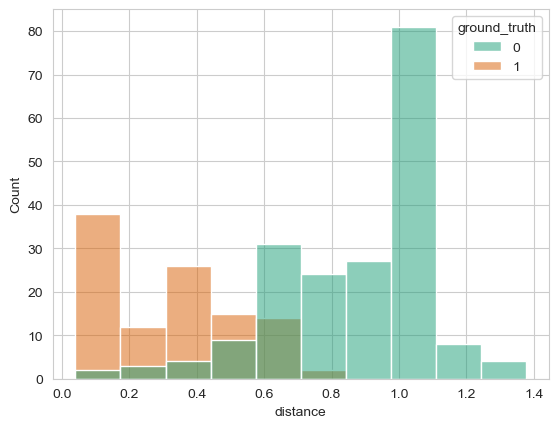

In [135]:
train_distances, _ = kc.best_classifer.kneighbors(knn_full_train)
train_eval_df = kc.aggregate_distances(y_train, train_distances, plot_histogram=True)

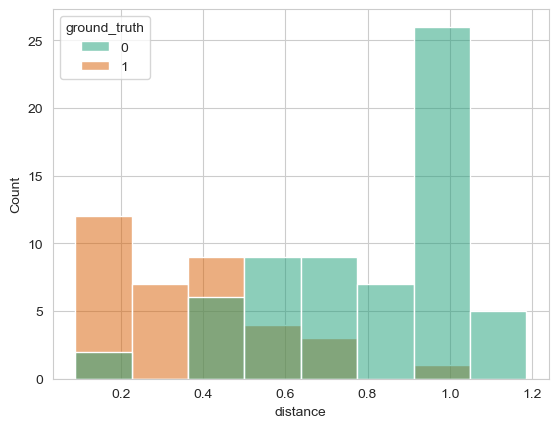

In [133]:
test_distances, _ = kc.best_classifer.kneighbors(knn_full_test)
test_eval_df = kc.aggregate_distances(y_test, test_distances, plot_histogram=True)

- Based on the chart, there is "0", but has a very close distance to the "1" cluster => this could be a potential look-a-like customers

In [137]:
# this is the customers who are class 0 but have a very close distance to "1" cluster
X_train.loc[train_eval_df[(train_eval_df.ground_truth == 0) & (train_eval_df.distance < 0.63)].index].head(5)

,Gender,Age,EstimatedSalary,Age_Bin
User ID,,,,
15579212,Male,39,77000,36-39
15695679,Female,41,60000,40-47
15794566,Female,52,114000,48-60
15724161,Female,50,44000,48-60
15680752,Female,43,133000,40-47


In [138]:
# Visualise the cluster 0 vs 1
pca = PCA(n_components=2)
pca_knn_full_train = pca.fit_transform(knn_full_train)

In [145]:
pca_knn_full_train_df = pd.DataFrame(pca_knn_full_train, columns = ['pca_1', 'pca_2'], index=y_train.index)
pca_knn_full_train_df['y'] = y_train

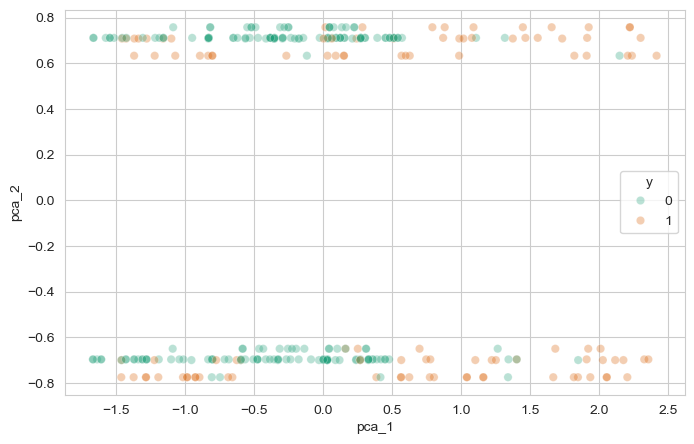

In [150]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="pca_1", y="pca_2",
    hue="y",
    data=pca_knn_full_train_df,
    palette ='Dark2',
    legend="full",
    alpha=0.3
)
plt.show()